In [1]:
import csv
import pandas as pd
import sys
#sys.path.append('./preprocess/')
#import utils
import re
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import MolToSmiles
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import rdChemReactions
from features import atom_features, bond_features
from rdkit.Chem.rdChemReactions import PreprocessReaction
from rdkit.Chem.SaltRemover import SaltRemover

In [2]:
# from patents: https://figshare.com/articles/Chemical_reactions_from_US_patents_1976-Sep2016_/5104873
data = pd.read_csv('./data/1976_Sep2016_USPTOgrants_smiles.csv', sep='\t', nrows=100000)
data

,ReactionSmiles,PatentNumber,ParagraphNum,Year,TextMinedYield,CalculatedYield
0,[Br:1][CH2:2][CH2:3][OH:4].[CH2:5]([S:7](Cl)(=...,US03930836,NaN,1976,NaN,NaN
1,[Br:1][CH2:2][CH2:3][CH2:4][OH:5].[CH3:6][S:7]...,US03930836,NaN,1976,NaN,NaN
2,[CH2:1]([Cl:4])[CH2:2][OH:3].CCOCC.[CH2:10]([S...,US03930836,NaN,1976,NaN,NaN
3,[Br:1][CH2:2][CH2:3][OH:4].[CH2:5]([S:7](Cl)(=...,US03930839,NaN,1976,NaN,NaN
4,[Br:1][CH2:2][CH2:3][CH2:4][OH:5].[CH3:6][S:7]...,US03930839,NaN,1976,NaN,NaN
...,...,...,...,...,...,...
99995,[CH3:1][C:2]1[CH2:3][S:4][C@@H:5]2[CH:12]([NH:...,US04348264,NaN,1982,82%,81.6%
99996,[CH3:1][C:2]1[CH2:3][S:4][C@@H:5]2[CH:12]([NH:...,US04348264,NaN,1982,NaN,19.2%
99997,[CH3:1][C:2]1[CH2:21][S:20][C@@H:5]2[C@H:6]([N...,US04348264,NaN,1982,NaN,55.1%
99998,[CH3:1][C:2]1[CH2:3][S:4][C@@H:5]2[CH:12]([NH:...,US04348264,NaN,1982,84%,84.1%


In [3]:
m = AllChem.MolFromSmiles('[Cl](F)(=[O])(=[O])=[O]',  sanitize=True)


In [4]:
remover = SaltRemover(defnData="[Cl,Br,Na]")

In [5]:
reactions = []
products = []
reactants = []
prod = ''
react = ''
counter = 0
counter2 = 0
for i in range(len(data.ReactionSmiles)):
    if i % 10000 == 0:
        print('zpracovano: ', i)
        
    if '>>' in data.ReactionSmiles[i]:

        line = re.sub(r'\|.+\|', '', data.ReactionSmiles[i])
        line = re.sub(':\d+', '', line)

        a, b = (line.split('>>'))    
        product = b.split('.')
        reactant = a.split('.')
        

        if len(b) > 100:
            counter2+=1
            cont = False
        elif len(a) > 100:
            counter2+=1
            cont = False
            
        else:
            cont = True
                
        if cont:

            try:
                for r in reactant:
                    # removal of ions
                    if len(r) > 5:
                        m = AllChem.MolFromSmiles(r, sanitize=True)
                        react += (AllChem.MolToSmiles(m)+'*')
              
                for p in product:
                    # removal of ions
                    if len(p) > 5:
                        m = AllChem.MolFromSmiles(p, sanitize=True)
                        prod += (AllChem.MolToSmiles(m)+'*')
                    
                    
                reactants.append(react)
                react = ''

                products.append(prod)
                prod = ''

            except:
                counter+=1
            
print(counter)
print(counter2)

zpracovano:  0
zpracovano:  10000
zpracovano:  20000
zpracovano:  30000
zpracovano:  40000
zpracovano:  50000
zpracovano:  60000
zpracovano:  70000
zpracovano:  80000
zpracovano:  90000
11
14842


In [6]:
len(reactants), len(products)

(10353, 10353)

In [7]:
products[0], reactants[0]

('Cc1cc2c([N+](=O)[O-])cccc2c(Cl)n1*',
 'Cc1cc2c([N+](=O)[O-])cccc2c[n+]1[O-]*O=P(Cl)(Cl)Cl*')

In [8]:
# save as smiles
with open('./data/smiles_reaction.txt', 'w',  newline='') as fin:
    writer = csv.writer(fin, delimiter='\t')
    for i, item in enumerate(reactants):
        writer.writerow([item, products[i]])

In [9]:
# converting molecules to pictures

In [10]:
charset = set("".join(list(reactants))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(react) for react in reactants]) + 5
print(str(charset))
print(len(charset), embed)

{')', 'b', 'A', 'n', 'e', '#', 'W', 'S', 'I', '2', 'g', 'U', 'F', '=', 'C', 'o', '3', '[', '1', '5', 'r', 'N', 'B', 'H', 'c', 't', '(', '-', '+', 'O', '\\', '/', '*', 'M', 'Z', 'T', 'L', '4', 'P', ']', 'E', 'a', 'i', 'l', 'u', '@', 's', '!', '6'}
49 123


In [11]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                #if j > 50:
                #    print(smile)
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [12]:
reactants_mat = vectorize(np.array(reactants))  
products_mat = vectorize(np.array(products))

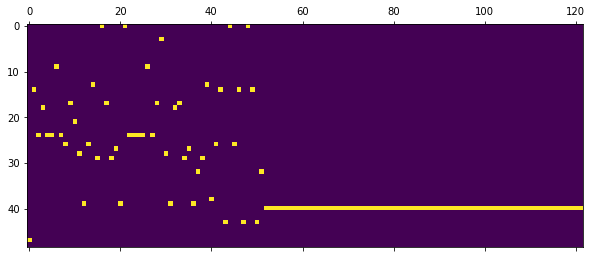

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.matshow(reactants_mat[0][0].T)

In [14]:
reactants_vec = reactants_mat[0].reshape((len(reactants_mat[0]), np.prod(reactants_mat[0].shape[1:])))
products_vec = products_mat[0].reshape((len(products_mat[0]), np.prod(products_mat[0].shape[1:])))
print(reactants_vec.shape)

(10353, 5978)


In [15]:
reactants_mat[0].shape, products_mat[0].shape

((10353, 122, 49), (10353, 122, 49))

In [16]:
# NETWORK

In [17]:
# packages
import matplotlib
matplotlib.use("Agg")
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
#from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
#import cv2
import os

Using TensorFlow backend.


In [18]:
(trainX, testX, trainY, testY) = train_test_split(reactants_vec, products_vec, test_size=0.25, random_state=42)
trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)

In [19]:
testX[0].shape[0]

5978

In [20]:
from keras.layers import Input, Dense
from keras.models import Model

# the size of  encoded representations
encoding_dim = int(testX[0].shape[0]/5) #  compression of factor 5
input_dim = int(testX[0].shape[0])


# this is our input placeholder
input_img = Input(shape=(input_dim,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [21]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [22]:
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [24]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [25]:
autoencoder.fit(trainX, trainY,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(testX, testY))


Train on 7764 samples, validate on 2589 samples
Epoch 1/20
7764/7764 [==============================] - 12s 2ms/step - loss: 0.6615 - val_loss: 0.5762
Epoch 2/20
7764/7764 [==============================] - 11s 1ms/step - loss: 0.3635 - val_loss: 0.1507
Epoch 3/20
7764/7764 [==============================] - 12s 1ms/step - loss: 0.0895 - val_loss: 0.0534
Epoch 4/20
7764/7764 [==============================] - 11s 1ms/step - loss: 0.0431 - val_loss: 0.0350
Epoch 5/20
7764/7764 [==============================] - 11s 1ms/step - loss: 0.0316 - val_loss: 0.0284
Epoch 6/20
7764/7764 [==============================] - 11s 1ms/step - loss: 0.0268 - val_loss: 0.0252
Epoch 7/20
7764/7764 [==============================] - 12s 2ms/step - loss: 0.0244 - val_loss: 0.0234
Epoch 8/20
7764/7764 [==============================] - 12s 1ms/step - loss: 0.0228 - val_loss: 0.0222
Epoch 9/20
7764/7764 [==============================] - 11s 1ms/step - loss: 0.0218 - val_loss: 0.0214
Epoch 10/20
7764/7764 [=

In [26]:
encoded_imgs = encoder.predict(trainX)
decoded_imgs = decoder.predict(encoded_imgs)

In [27]:
encoded_imgs.shape, decoded_imgs.shape

((7764, 1195), (7764, 5978))

In [43]:
index = 1

In [44]:
orig = testY[index].reshape(122, 49)
#y = np.rint(decoded_imgs[index])
y = decoded_imgs[index]
print(y)
y = y.reshape(122, 49)

[0.00104669 0.00115448 0.0011436  ... 0.00099131 0.00119534 0.00107843]


In [45]:
back_y = "".join([int_to_char[idx] for idx in np.argmax(y, axis=1)])
back_orig = "".join([int_to_char[idx] for idx in np.argmax(orig, axis=1)])

In [46]:
back_y, back_orig

('!CCCCCcCCCccCcccccccEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE',
 '!O=C(O)CSSc1ccc([N+](=O)[O-])cc1C(Cl)(Cl)Cl*EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE')

In [47]:
y[0]

array([1.0466874e-03, 1.1544824e-03, 1.1436045e-03, 1.0838807e-03,
       1.0433495e-03, 1.1506081e-03, 1.0864437e-03, 1.0245144e-03,
       1.1188984e-03, 9.1770291e-04, 9.7304583e-04, 1.1188686e-03,
       1.0603666e-03, 1.0266006e-03, 1.0350347e-03, 1.1544228e-03,
       1.1497438e-03, 1.1318624e-03, 1.1562109e-03, 9.2723966e-04,
       1.0903776e-03, 8.4847212e-04, 1.1177659e-03, 1.0230243e-03,
       1.0372996e-03, 1.1352897e-03, 1.1260211e-03, 1.0074377e-03,
       9.3400478e-04, 1.0270774e-03, 1.1471808e-03, 1.0041296e-03,
       1.1295974e-03, 9.8440051e-04, 1.1720061e-03, 1.2400746e-03,
       1.1460781e-03, 1.0722876e-03, 1.0526478e-03, 1.1911988e-03,
       1.1049509e-03, 7.8067183e-04, 1.1450052e-03, 1.0838509e-03,
       1.0108650e-03, 1.0353625e-03, 1.2192428e-03, 9.9881023e-01,
       1.1834502e-03], dtype=float32)

In [48]:
np.argmax(y[0])

47

In [49]:
b = np.argmax(y, axis=1)

In [50]:
b

array([47, 14, 14, 14, 14, 14, 24, 14, 14, 14, 24, 24, 14, 24, 24, 24, 24,
       24, 24, 24, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40], dtype=int64)

In [60]:
np.array(reactants_mat)[0].shape

(10353, 122, 49)

In [61]:
(trainX, testX, trainY, testY) = train_test_split(np.array(reactants_mat)[0], np.array(products_mat)[0], test_size=0.25, random_state=42)


In [62]:
#Import Keras objects
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras import regularizers
input_shape = trainX.shape[1:]
output_dim = trainY.shape[-1]
latent_dim = 64
lstm_dim = 64

In [63]:
input_shape, output_dim , trainX.shape

((122, 49), 49, (7764, 122, 49))

In [64]:
unroll = False
encoder_inputs = Input(shape=input_shape)
encoder_inputs

<tf.Tensor 'input_7:0' shape=(?, 122, 49) dtype=float32>

In [65]:
encoder = LSTM(lstm_dim, return_state=True,
                unroll=unroll)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim, activation="relu")
neck_outputs = neck(states)

In [66]:
decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll
                   )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
# Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 122, 49)      0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 64), (None,  29184       input_7[0][0]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 128)          0           lstm_6[0][1]                     
                                                                 lstm_6[0][2]                     
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 64)           8256        concatenate_4[0][0]              
__________

In [67]:
from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)

C:\Users\kamcl\Miniconda3\envs\reaction_ml\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [68]:
from keras.optimizers import RMSprop, Adam
opt=Adam(lr=0.005) # 0.001
model.compile(optimizer=opt, loss='categorical_crossentropy')

model.fit([trainX,trainX],trainY,
                    epochs=60,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=[[testX,testX],testY])

Train on 7764 samples, validate on 2589 samples
Epoch 1/60
7764/7764 [==============================] - 13s 2ms/step - loss: 1.3212 - val_loss: 0.6715
Epoch 2/60
7764/7764 [==============================] - 11s 1ms/step - loss: 0.6436 - val_loss: 0.6243
Epoch 3/60
7764/7764 [==============================] - 14s 2ms/step - loss: 0.6154 - val_loss: 0.6069
Epoch 4/60
7764/7764 [==============================] - 10s 1ms/step - loss: 0.6030 - val_loss: 0.5958
Epoch 5/60
7764/7764 [==============================] - 12s 2ms/step - loss: 0.6747 - val_loss: 0.6162
Epoch 6/60
7764/7764 [==============================] - 10s 1ms/step - loss: 0.5988 - val_loss: 0.5843
Epoch 7/60
7764/7764 [==============================] - 12s 2ms/step - loss: 0.5797 - val_loss: 0.5721
Epoch 8/60
7764/7764 [==============================] - 10s 1ms/step - loss: 0.5712 - val_loss: 0.5653
Epoch 9/60
7764/7764 [==============================] - 9s 1ms/step - loss: 0.5630 - val_loss: 0.5638
Epoch 10/60
7764/7764 [===

In [70]:
import pickle
pickle.dump(h.history, open("loss_history.pickle","wb"))

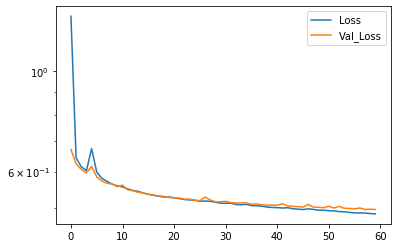

In [71]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

In [73]:
for i in range(10):
    v = model.predict([testX[i:i+1], testX[i:i+1]])
    idxs = np.argmax(v, axis=2)
    pred=  "".join([int_to_char[h] for h in idxs[0]])[:-1]
    idxs2 = np.argmax(testY[i:i+1], axis=2)
    true =  "".join([int_to_char[k] for k in idxs2[0]])[1:]
    if true != pred:
        print(true[0:50], pred[0:50])

CCOC(=O)C(C)CCCCCC1=CCCC1=O*EEEEEEEEEEEEEEEEEEEEEE !CC(CCCCCCCCCCCCCCCCCCCCCEEEEEEEEEEEEEEEEEEEEEEEEE
O=C(O)CSSc1ccc([N+](=O)[O-])cc1C(Cl)(Cl)Cl*EEEEEEE !O=[Nc]([O-])ccccccEEEEccc)CC)))l))E))EEEEEEEEEEEE
CCOC(=O)/C=C\C(=O)[O-]*[Na+]*EEEEEEEEEEEEEEEEEEEEE !O=C1C=CC(=O)CCCO=C(EEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
ClC(Cn1ccnc1)c1cccc2ccccc12*EEEEEEEEEEEEEEEEEEEEEE !OCCCn1ccncccccccccccccccc2cEEEEEEEEEEEEEEEEEEEEEE
CC1=NCCn2cccc21*EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE !CC(=O)NCCC1cccccEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
O=C(O)C#CC1CCCCC1Cl*EEEEEEEEEEEEEEEEEEEEEEEEEEEEEE !CCCC(=O)C(CCCC(CCCCECCEEEEEEEEEEEEEEEEEEEEEEEEEEE
CCc1cc(CC)c2ccc(N)nc2n1*EEEEEEEEEEEEEEEEEEEEEEEEEE !O=P(O)(O)OONccccccccccc*EEEEEEEEEEEEEEEEEEEEEEEEE
NC(=O)C1(N)CCCCC1*EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE !O=C(=O)(O)OONN)CCCEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
O=S(=O)([O-])F*C[n+]1sc(Cl)c(C#N)c1Cl*EEEEEEEEEEEE !N#Cc1c(CC)ccccCCCCEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
C#CCn1c2ccccc2c2sccc(=O)c21*EEEEEEEEEEEEEEEEEEEEEE !O=c1cccccccccccccccccccccccccc

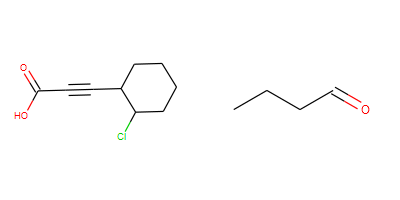

In [87]:
m_true = AllChem.MolFromSmiles('O=C(O)C#CC1CCCCC1Cl')
m_pred = AllChem.MolFromSmiles('CCCC(=O)')
Draw.MolsToImage([m_true, m_pred])

In [78]:
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)
smiles_to_latent_model.save("Blog_simple_smi2lat.h5")

In [79]:
latent_input = Input(shape=(latent_dim,))
#reuse_layers
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.save("lat2state.h5")

In [80]:
#Last one is special, we need to change it to stateful, and change the input shape
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))
inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    stateful=True
                   )
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

In [81]:
#Transfer Weights
for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+6].get_weights())
sample_model.save("samplemodel.h5")
1
sample_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (1, 1, 49)                0         
_________________________________________________________________
lstm_8 (LSTM)                (1, 1, 64)                29184     
_________________________________________________________________
dense_16 (Dense)             (1, 1, 49)                3185      
Total params: 32,369
Trainable params: 32,369
Non-trainable params: 0
_________________________________________________________________


In [82]:
# similarity TODO

In [83]:
x_latent = smiles_to_latent_model.predict(testX)

[<rdkit.Chem.rdchem.Mol object at 0x0000021B0852F7B0>, <rdkit.Chem.rdchem.Mol object at 0x0000021B0A61BAD0>]


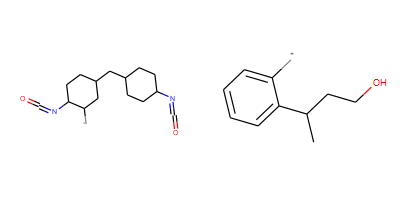

In [84]:
molno = 5
latent_mol = smiles_to_latent_model.predict(testX[molno:molno+1])
sorti = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))
#print(sorti[0:10])
#print(testY[sorti[0:2]])
mols = []
for i in range(2):
    mols.append(Chem.MolFromSmiles(products[sorti[i]]))
print(mols)
Draw.MolsToImage(mols)